##### Key motivation is to plot IV surfaces of european options
##### Secondary motivation is to investigate price difference of theoretical bsm model with actual call option prices
##### Using surface plots for easy visualization of anomalies

In [137]:
# Imports
# Data manipulation
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
# Maths
from scipy.stats import norm
# Visualisation
import matplotlib.pyplot as plt


In [138]:
# Fetch Options Chain from Yahoo Finance
def option_chains(ticker):
    """
    Get option chains for a given ticker

    Parameters
    ticker : str
        Ticker symbol
    
    Returns
    options chain : pd.DataFrame
        DataFrame with option chain data
    """
    asset = yf.Ticker(ticker)
    expirations = asset.options
    
    chains = pd.DataFrame()
    
    for expiration in expirations:
        # tuple of two dataframes
        opt = asset.option_chain(expiration)
        
        calls = opt.calls
        calls['optionType'] = "call"
        
        puts = opt.puts
        puts['optionType'] = "put"
        
        chain = pd.concat([calls, puts])
        chain['expiration'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        
        chains = pd.concat([chains, chain])
    
    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1
    
    return chains

# Black-Scholes-Merton Pricing Model
def black_scholes_merton(S, K, T, r, sigma, option_type='call'):
    """
    Calculate the price of a European option using the Black-Scholes-Merton model

    d1 = (ln(S / K) + (r + 0.5 * sigma^2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    Parameters
    S : float
        Current stock price
    K : float
        Option strike price
    T : float
        Time to expiration in years
    r : float
        Risk-free rate
    sigma : float
        Volatility of the underlying stock
    option_type : str
        Type of option (call or put)
    
    Returns
    option price : float
        Price of the option
    """

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [139]:
# Define parameters
today = dt.datetime.today()
today = today.strftime("%Y-%m-%d %H:%M:%S")
risk_free_rate = 0.0453  # SONIA 10-year rate

# Tickers of interest
tickers = ["AAPL", "TSLA", "PLTR", "SPY"]


##### Market Values

In [140]:
options = pd.DataFrame()
ticker_chain = {}

# Fetch options chain for each ticker
for ticker in tickers:
    ticker_options = option_chains(ticker)
    ticker_options["ticker"] = ticker
    options = pd.concat([options, ticker_options])
    ticker_chain[ticker] = ticker_options

calls = options[options["optionType"] == "call"] # Extract calls
calls = calls[calls['impliedVolatility'] >= 0.001] # Filter out options with low IV

# Get current underlying prices - latest close price
underlying_prices = {ticker: yf.Ticker(ticker).history(period="1d")['Close'].iloc[-1] for ticker in tickers}

In [141]:
# PLTR = yf.Ticker("PLTR").option_chain(min(yf.Ticker("PLTR").options))
# print(PLTR)
# ticker_chain["PLTR"].head()

In [142]:
#calls[calls['impliedVolatility'] >= 0.001].head(5)
#calls[calls['expiration'] > today].head(5)
#calls[calls['inTheMoney'] == False].head(5)

##### BSM

In [143]:
# Apply BSM model, then
# Calculate price difference and add as a column to each dataframe in ticker_chain, and implied volatility
for ticker in ticker_chain:
    ticker_chain[ticker]['BSM_Price'] = ticker_chain[ticker].apply(lambda row: black_scholes_merton(
        S=underlying_prices[row['ticker']],
        K=row['strike'],
        T=row['daysToExpiration'] / 365,
        r=risk_free_rate,
        sigma=row['impliedVolatility'],
        option_type=row['optionType']
    ), axis=1)
    ticker_chain[ticker]['Price_Diff'] = ticker_chain[ticker]['lastPrice'] - ticker_chain[ticker]['BSM_Price']


# Calculate correlation between bsm model and last price
prices_corr = {}
for ticker in ticker_chain:
    prices_corr[ticker] = ticker_chain[ticker]['lastPrice'].corr(ticker_chain[ticker]['BSM_Price'])

C:\Users\ayode\AppData\Local\Temp\ipykernel_25000\1111982621.py:65: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


##### Plotting

In [144]:
options.head(5)

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expiration,daysToExpiration,ticker
0,AAPL250207C00100000,2025-02-03 20:20:30+00:00,100.0,128.70,130.30,131.00,0.0,0.0,4.0,32.0,0.00001,True,REGULAR,USD,call,2025-02-07 23:59:59,3,AAPL
1,AAPL250207C00110000,2025-01-31 19:41:43+00:00,110.0,124.44,120.30,121.05,0.0,0.0,1.0,11.0,0.00001,True,REGULAR,USD,call,2025-02-07 23:59:59,3,AAPL
2,AAPL250207C00120000,2025-01-29 19:56:22+00:00,120.0,118.30,110.40,111.20,0.0,0.0,NaN,4.0,0.00001,True,REGULAR,USD,call,2025-02-07 23:59:59,3,AAPL
3,AAPL250207C00130000,2025-02-04 16:55:44+00:00,130.0,102.00,100.25,101.05,0.0,0.0,1.0,1.0,0.00001,True,REGULAR,USD,call,2025-02-07 23:59:59,3,AAPL
4,AAPL250207C00140000,2025-02-04 14:30:07+00:00,140.0,87.17,90.40,91.00,0.0,0.0,1.0,3.0,0.00001,True,REGULAR,USD,call,2025-02-07 23:59:59,3,AAPL


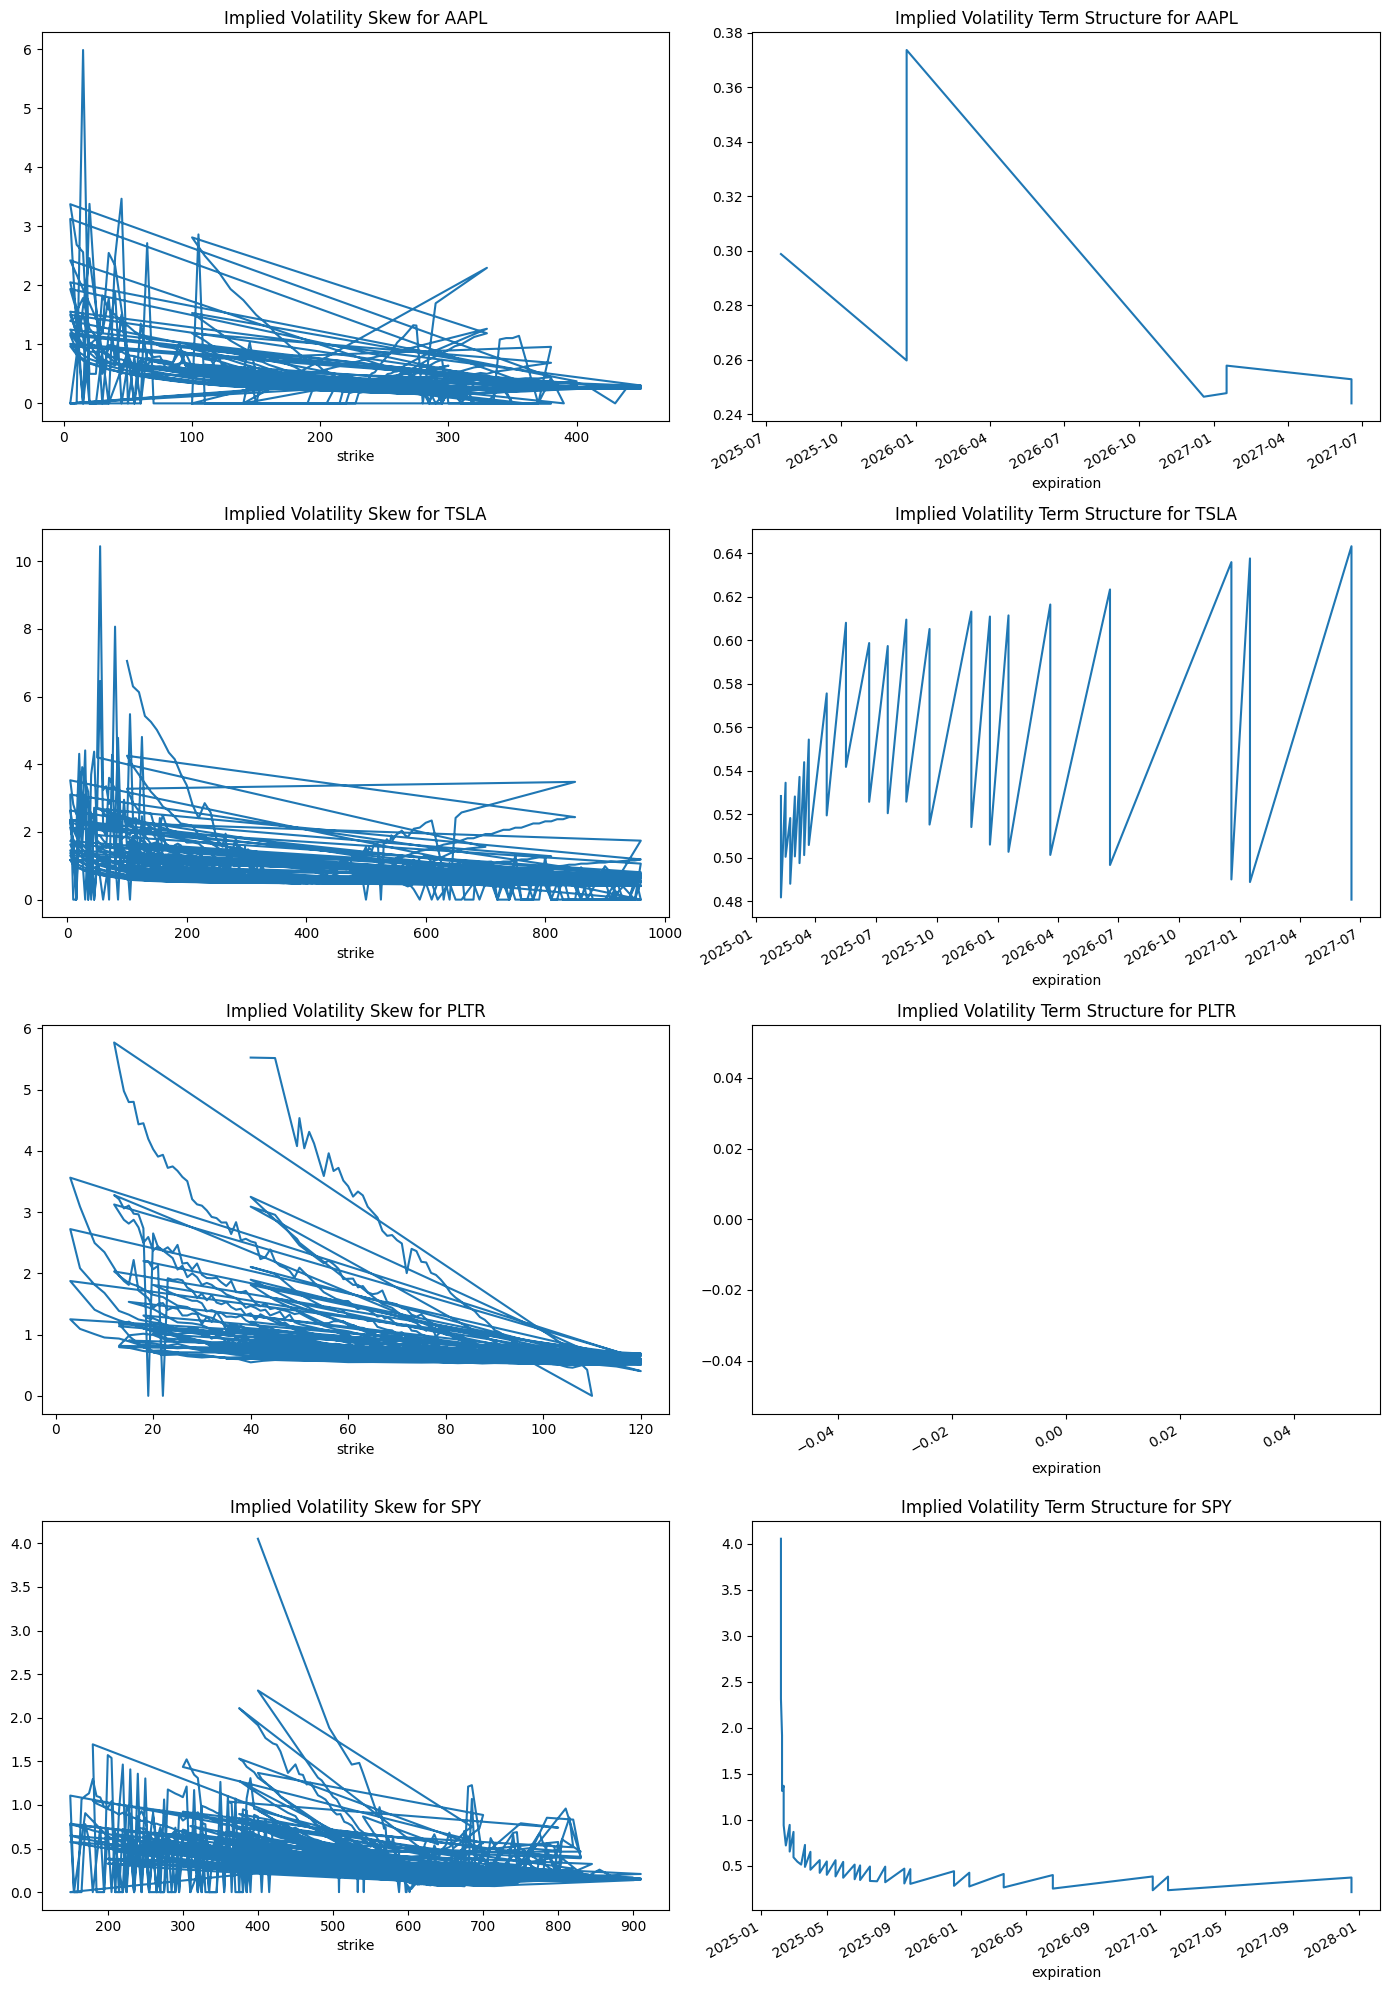

In [145]:
fig, axs = plt.subplots(4, 2, figsize=(14, 20))

for i, ticker in enumerate(tickers):
    calls = ticker_chain[ticker]
    
    # Plot Implied Volatility Skew
    calls_at_expiry = calls[calls["expiration"] > today]
    calls_at_expiry[["strike", "impliedVolatility"]].set_index("strike").plot(
        ax=axs[i, 0], title=f"Implied Volatility Skew for {ticker}", legend=False
    )
    
    # Plot Implied Volatility Term Structure
    calls_at_strike = calls[calls["strike"] == 400.0]
    calls_at_strike[["expiration", "impliedVolatility"]].set_index("expiration").plot(
        ax=axs[i, 1], title=f"Implied Volatility Term Structure for {ticker}", legend=False
    )

# Adjust layout
fig.tight_layout()
plt.show()

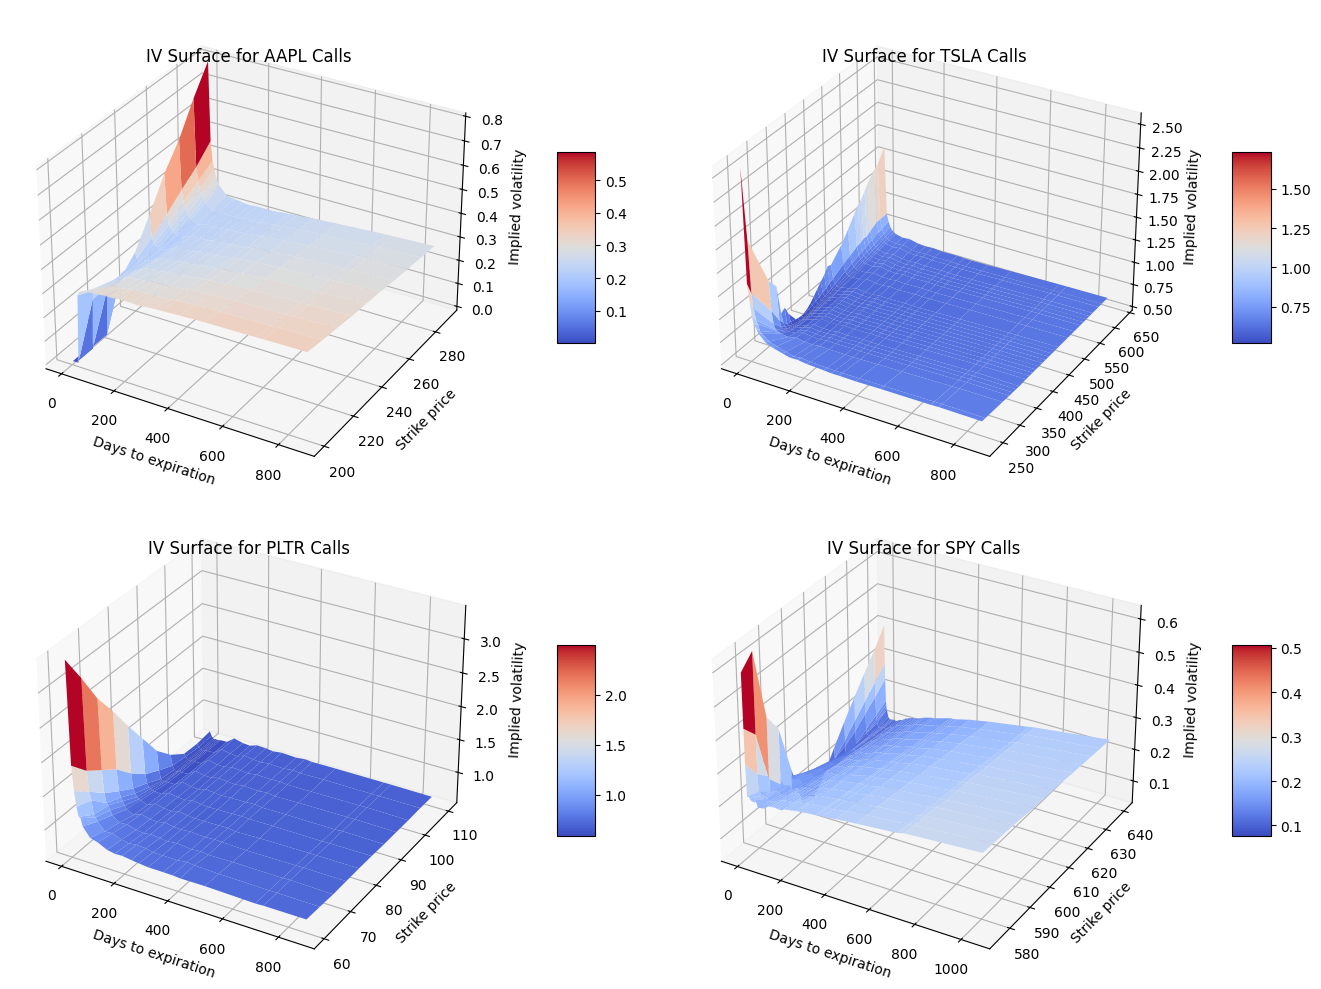

In [146]:
# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(14, 10))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Iterate over each ticker and plot the IV surface
for i, ticker in enumerate(tickers):
    calls_at_expiry = ticker_chain[ticker][ticker_chain[ticker]["optionType"] == "call"]
    
    # Pivot the dataframe
    surface = (
        calls_at_expiry[['daysToExpiration', 'strike', 'impliedVolatility']]
        .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration')
        .dropna()
    )
    
    if not surface.empty:
        # Get the 1D values from the pivoted dataframe
        x, y, z = surface.columns.values, surface.index.values, surface.values

        # Return coordinate matrices from coordinate vectors
        X, Y = np.meshgrid(x, y)

        # Plot the surface
        ax = axs[i]
        surf = ax.plot_surface(X, Y, z, cmap='coolwarm')

        # Set labels
        ax.set_xlabel('Days to expiration')
        ax.set_ylabel('Strike price')
        ax.set_zlabel('Implied volatility')
        ax.set_title(f'IV Surface for {ticker} Calls', y=0.95)

        # Add color bar
        fig.colorbar(surf, ax=ax, shrink=0.4, aspect=5, pad=0.1)

# Adjust layout
fig.tight_layout()
plt.show()

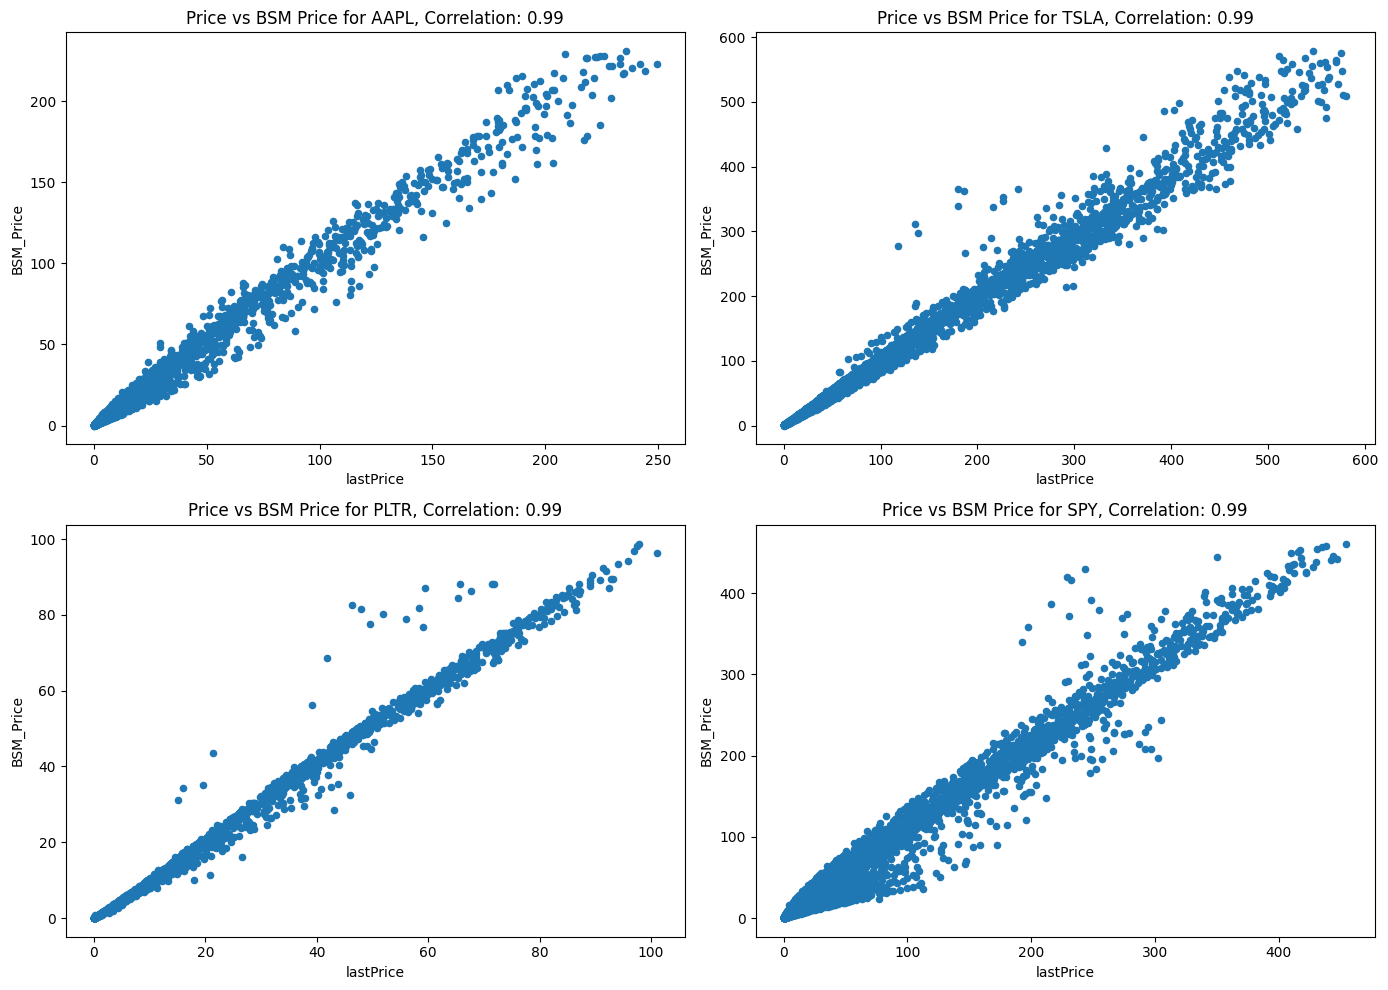

In [147]:
# Plot prices vs BSM prices
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, ticker in enumerate(tickers):
    if i >= 4:
        break
    calls = ticker_chain[ticker]
    
    # Plot Implied Volatility Skew
    calls.plot.scatter(
        x="lastPrice", y="BSM_Price", ax=axs[i // 2, i % 2], title=f"Price vs BSM Price for {ticker}, Correlation: {prices_corr[ticker]:.2f}"
    )
    
    # # Plot Implied Volatility Term Structure
    # calls_at_strike = calls[calls["strike"] == 400.0]
    # calls_at_strike.plot.scatter(
    #     x="lastPrice", y="BSM_Price", ax=axs[i // 2, i % 2], title=f"Price vs BSM Price for {ticker}"
    # )

# Adjust layout
fig.tight_layout()
plt.show()

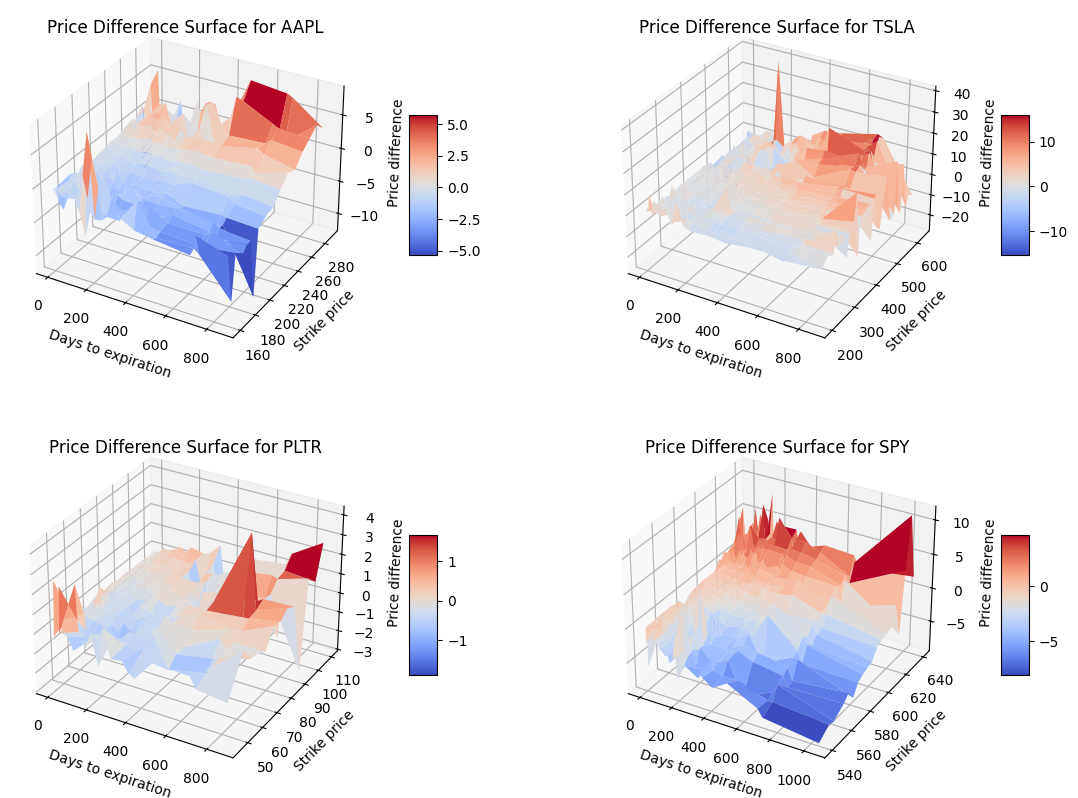

In [151]:
# Plot price difference surface
fig, axs = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(14, 10))

for i, ticker in enumerate(tickers):
    calls = ticker_chain[ticker]
    
    # Pivot the dataframe
    surface = (
        calls[['daysToExpiration', 'strike', 'Price_Diff']]
        .pivot_table(values='Price_Diff', index='strike', columns='daysToExpiration')
        .dropna()
    )
    
    if not surface.empty:
        # Get the 1D values from the pivoted dataframe
        x, y, z = surface.columns.values, surface.index.values, surface.values

        # Return coordinate matrices from coordinate vectors
        X, Y = np.meshgrid(x, y)

        # Plot the surface
        ax = axs[i // 2, i % 2]
        surf = ax.plot_surface(X, Y, z, cmap='coolwarm')

        # Set labels
        ax.set_xlabel('Days to expiration')
        ax.set_ylabel('Strike price')
        ax.set_zlabel('Price difference')
        ax.set_title(f'Price Difference Surface for {ticker}', y=0.99)

        # Add color bar
        fig.colorbar(surf, ax=ax, shrink=0.4, aspect=5, pad=0.1)